<a href="https://colab.research.google.com/github/ally-ds/TensorFlow/blob/master/Recycle_Image_Classfication_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!unzip /content/drive/"My Drive"/dataset/recycle.zip  -d /content/drive/"My Drive"/

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
folder_name = '/content/drive/My Drive/dataset'
base_dir = os.path.join(folder_name)

In [38]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape
print(len(train_generator), len(val_generator))


Found 5142 images belonging to 4 classes.
Found 570 images belonging to 4 classes.
81 9


In [39]:
print (train_generator.class_indices)

{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}


In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [0]:
base_model.trainable = False

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
81/81 [==============================] - 85s 1s/step - loss: 0.9357 - accuracy: 0.6593 - val_loss: 0.7699 - val_accuracy: 0.7263
Epoch 2/10
81/81 [==============================] - 83s 1s/step - loss: 0.6653 - accuracy: 0.7423 - val_loss: 0.7232 - val_accuracy: 0.7351
Epoch 3/10
81/81 [==============================] - 84s 1s/step - loss: 0.6046 - accuracy: 0.7629 - val_loss: 0.7015 - val_accuracy: 0.7404
Epoch 4/10
81/81 [==============================] - 83s 1s/step - loss: 0.5777 - accuracy: 0.7692 - val_loss: 0.6722 - val_accuracy: 0.7596
Epoch 5/10
81/81 [==============================] - 83s 1s/step - loss: 0.5538 - accuracy: 0.7800 - val_loss: 0.7601 - val_accuracy: 0.7175
Epoch 6/10
81/81 [==============================] - 84s 1s/step - loss: 0.5315 - accuracy: 0.7909 - val_loss: 0.6477 - val_accuracy: 0.7684
Epoch 7/10
81/81 [==============================] - 83s 1s/step - loss: 0.5094 - accuracy: 0.8001 - val_loss: 0.6406 - val_accuracy: 0.7456
Epoch 8/10
81/81 [==

In [45]:
class_names = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Glass', 'Metal', 'Paper', 'Plastic'], dtype='<U7')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

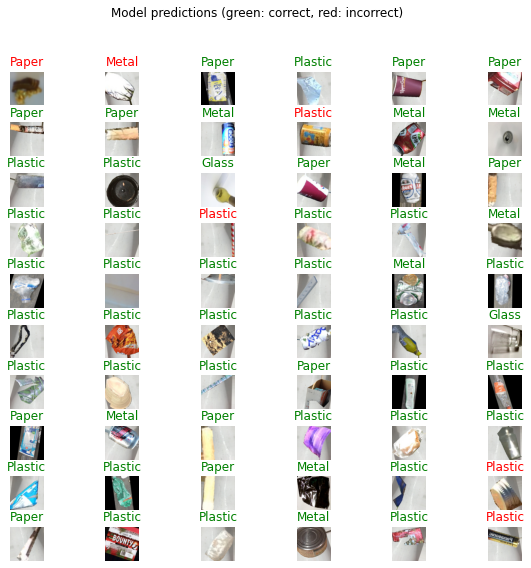

In [47]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(60):
  plt.subplot(10,6,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [48]:
test_folder_name = '/content/drive/My Drive/real_test'
test_dir = os.path.join(test_folder_name)

IMAGE_SIZE = 224
BATCH_SIZE = 64

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)


for test_image_batch, test_label_batch in test_generator:
  break
test_image_batch.shape, test_label_batch.shape

Found 8 images belonging to 4 classes.


((8, 224, 224, 3), (8, 4))

In [0]:
real_batch = model.predict(test_image_batch)
real_id = np.argmax(real_batch, axis=-1)

real_label_batch = class_names[real_id]
real_label_id = np.argmax(test_label_batch, axis=-1)

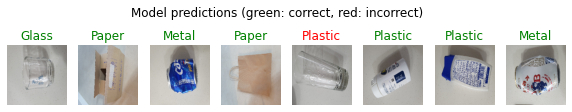

In [50]:
plt.figure(figsize=(10,2))
plt.subplots_adjust(hspace=0.5)
for n in range(8):
  plt.subplot(1,8,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if real_id[n] == real_label_id[n] else "red"
  plt.title(real_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")